<a href="https://colab.research.google.com/github/17092003vamsi/HUNTER/blob/main/roc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.1980 - loss: 1.8101 - val_accuracy: 0.3158 - val_loss: 1.7106
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4132 - loss: 1.6866 - val_accuracy: 0.4737 - val_loss: 1.6046
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 1.5809 - val_accuracy: 0.7895 - val_loss: 1.5035
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7811 - loss: 1.4974 - val_accuracy: 0.7895 - val_loss: 1.4062
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 1.4282 - val_accuracy: 0.7895 - val_loss: 1.3147
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7859 - loss: 1.3182 - val_accuracy: 0.7895 - val_loss: 1.2173
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8103 - loss: 1.2238 - val_accuracy: 0.8421 - val_loss: 1.1147
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8431 - loss: 1.1183 - val_accuracy: 0.8421 - val_loss: 1.0076
E

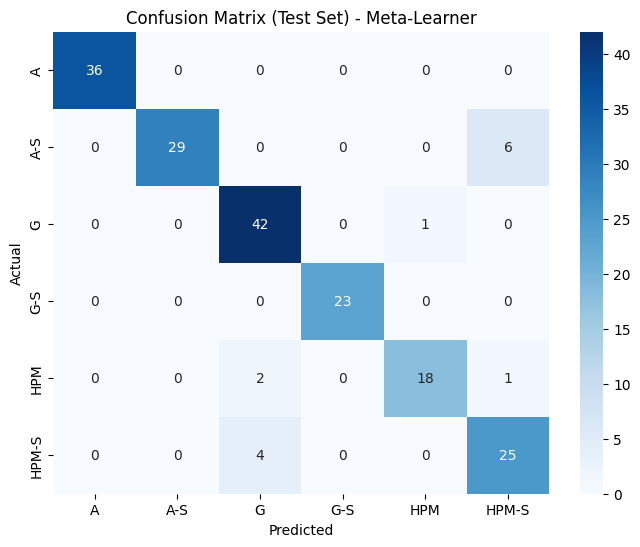

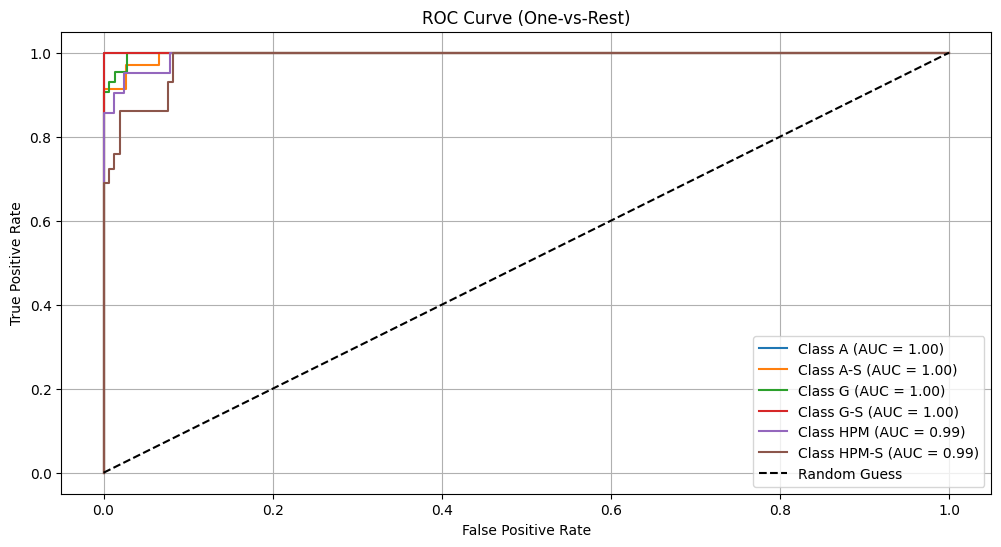

Calculating SHAP values for Random Forest...


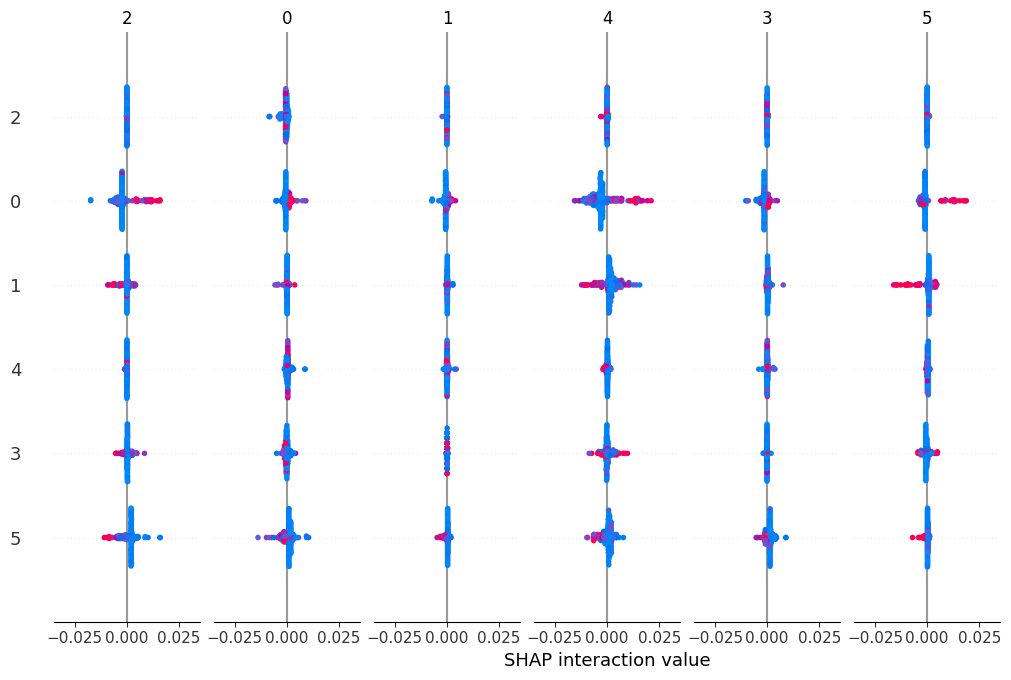

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import shap

# Load the dataset
file_path = '/content/project 2 sap.csv'  # Update this path
data = pd.read_csv(file_path)

# Preprocessing
label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])  # Encode target labels
y = data['Lable']
X = data.drop(columns=['Type', 'Lable'])

# Handle missing values and scale features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode the labels for the neural network
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Base models
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True)

# Train base models
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Validation probabilities
knn_val_proba = knn_model.predict_proba(X_val)
rf_val_proba = rf_model.predict_proba(X_val)
svm_val_proba = svm_model.predict_proba(X_val)

# Ensure consistent sizes
assert knn_val_proba.shape[0] == y_val.shape[0], "KNN probabilities do not match validation labels!"
assert rf_val_proba.shape[0] == y_val.shape[0], "RF probabilities do not match validation labels!"
assert svm_val_proba.shape[0] == y_val.shape[0], "SVM probabilities do not match validation labels!"

# Stacking meta-features for validation
meta_X_val = np.hstack((knn_val_proba, rf_val_proba, svm_val_proba))

# Define and train the meta-learner
meta_learner = Sequential([
    Dense(32, activation='relu', input_shape=(meta_X_val.shape[1],)),
    Dense(16, activation='relu'),
    Dense(y_val_onehot.shape[1], activation='softmax')
])

meta_learner.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the meta-learner
history = meta_learner.fit(
    meta_X_val, y_val_onehot,
    validation_split=0.1,
    epochs=20,
    batch_size=16,
    verbose=1
)

# Test probabilities
knn_test_proba = knn_model.predict_proba(X_test)
rf_test_proba = rf_model.predict_proba(X_test)
svm_test_proba = svm_model.predict_proba(X_test)

# Ensure consistent sizes for test data
assert knn_test_proba.shape[0] == y_test.shape[0], "KNN probabilities do not match test labels!"
assert rf_test_proba.shape[0] == y_test.shape[0], "RF probabilities do not match test labels!"
assert svm_test_proba.shape[0] == y_test.shape[0], "SVM probabilities do not match test labels!"

meta_X_test = np.hstack((knn_test_proba, rf_test_proba, svm_test_proba))
meta_test_preds_proba = meta_learner.predict(meta_X_test)
meta_test_preds = np.argmax(meta_test_preds_proba, axis=1)

# Accuracy scores
print(f"KNN Test Accuracy: {accuracy_score(y_test, knn_model.predict(X_test)):.4f}")
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, rf_model.predict(X_test)):.4f}")
print(f"SVM Test Accuracy: {accuracy_score(y_test, svm_model.predict(X_test)):.4f}")
print(f"Meta-Learner Test Accuracy: {accuracy_score(y_test, meta_test_preds):.4f}")

# Classification reports
target_names = label_encoder.inverse_transform(np.unique(y))

print("\nKNN Classification Report:")
print(classification_report(y_test, knn_model.predict(X_test), target_names=target_names))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_model.predict(X_test), target_names=target_names))

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_model.predict(X_test), target_names=target_names))

print("\nMeta-Learner Classification Report:")
print(classification_report(y_test, meta_test_preds, target_names=target_names))

# Confusion matrix for Meta-Learner
conf_matrix = confusion_matrix(y_test, meta_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Test Set) - Meta-Learner')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for Meta-Learner
plt.figure(figsize=(12, 6))
for i, class_label in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_test == i, meta_test_preds_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SHAP for Random Forest
print("Calculating SHAP values for Random Forest...")
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Plot SHAP summary for Random Forest
shap.summary_plot(shap_values_rf, X_test, feature_names=data.drop(columns=['Type', 'Lable']).columns)
